# Pokémon Cry Stats Predictor - Analysis Notebook

このノートブックでは、ポケモンの鳴き声から複数ステータスを予測する機械学習モデルの構築と評価を行います。

## 0. 日本語フォント設定

In [10]:
import matplotlib.pyplot as plt
import matplotlib

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 利用可能なフォントを確認
import subprocess
try:
    result = subprocess.run(['fc-list', ':lang=ja'], capture_output=True, text=True, timeout=5)
    if 'Noto Sans CJK JP' in result.stdout:
        plt.rcParams['font.family'] = 'Noto Sans CJK JP'
        print("✅ 日本語フォント設定: Noto Sans CJK JP")
    elif 'IPAGothic' in result.stdout or 'IPAexGothic' in result.stdout:
        plt.rcParams['font.family'] = 'IPAexGothic'
        print("✅ 日本語フォント設定: IPAexGothic")
    else:
        print("⚠️ 日本語フォント未検出。グラフの日本語が文字化けする可能性があります。")
        print("   回避策: ラベルをASCII文字のみで表示します。")
        plt.rcParams['font.family'] = 'DejaVu Sans'
except Exception as e:
    print(f"⚠️ フォント検出エラー: {e}")
    print("   デフォルトフォントを使用します。")

✅ 日本語フォント設定: IPAexGothic


## 1. データの読み込みと確認

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# スタイル設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ ライブラリのインポート完了")

✅ ライブラリのインポート完了


In [12]:
# データ読み込み
df = pd.read_csv("../data/processed_features.csv")

print(f"データサイズ: {df.shape}")
print(f"\nポケモン数: {len(df)}")
print(f"\n列名:\n{df.columns.tolist()}")

# 最初の数行を表示
df.head()

データサイズ: (100, 37)

ポケモン数: 100

列名:
['mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'zcr', 'spectral_centroid', 'rolloff', 'name', 'species_id', 'hp', 'attack', 'defense', 'speed', 'sp_attack', 'sp_defense']


,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,spectral_centroid,rolloff,name,species_id,hp,attack,defense,speed,sp_attack,sp_defense
0,-32.999740,16.798803,-57.957058,34.076466,13.402184,-3.852666,-7.704761,11.399326,8.943667,11.736207,...,3264.820544,5421.920113,doduo,84,35,85,45,75,35,35
1,-37.169570,77.908150,-24.656599,28.789042,12.666594,-8.260133,-6.607128,6.101888,-8.231573,1.497806,...,2541.943275,4597.601467,spearow,21,40,60,30,70,31,31
2,-1.040649,87.878555,11.763952,30.777775,8.081284,17.505596,0.598770,14.446560,3.700900,4.649940,...,2311.548548,5690.268555,magnemite,81,25,35,70,45,95,55
3,-45.110504,84.986490,-34.315754,3.895207,-11.034429,5.046232,-11.000435,4.422132,0.514519,5.466674,...,2311.440820,4549.145508,wigglytuff,40,140,70,45,45,85,50
4,-69.364980,89.803720,-45.843400,-19.517000,2.391003,1.060515,-14.437530,4.756642,-3.568961,4.657822,...,2276.630142,3710.170898,farfetchd,83,52,90,55,60,58,62


## 2. データの準備と分割

In [13]:
# 特徴量とターゲットの定義
TARGET_STATS = ["hp", "attack", "defense", "speed", "sp_attack", "sp_defense"]

# 音響特徴量を抽出
feature_cols = []
feature_cols.extend([col for col in df.columns if col.startswith("mfcc_mean_")])
feature_cols.extend([col for col in df.columns if col.startswith("mfcc_std_")])
feature_cols.extend(["zcr", "spectral_centroid", "rolloff"])

X = df[feature_cols]
y = df[TARGET_STATS]

print(f"特徴量の形状: {X.shape}")
print(f"ターゲットの形状: {y.shape}")
print(f"\n特徴量の数: {X.shape[1]}")
print(f"予測するステータス: {TARGET_STATS}")

特徴量の形状: (100, 29)
ターゲットの形状: (100, 6)

特徴量の数: 29
予測するステータス: ['hp', 'attack', 'defense', 'speed', 'sp_attack', 'sp_defense']


In [14]:
# トレーニング/テスト分割 (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"トレーニングセット: {len(X_train)} サンプル")
print(f"テストセット: {len(X_test)} サンプル")

トレーニングセット: 80 サンプル
テストセット: 20 サンプル


## 3. ベースラインモデルの学習（RandomForest, 29次元特徴量）

In [15]:
# RandomForestRegressorをMultiOutputRegressorでラップ
base_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model = MultiOutputRegressor(base_model)

print("モデル学習中...")
model.fit(X_train, y_train)
print("✅ モデル学習完了")

モデル学習中...
✅ モデル学習完了


## 4. ベースラインモデルの評価

In [16]:
# 予測
y_pred = model.predict(X_test)

# 各ステータスごとに評価
print("=== テストセットでの評価結果（ベースライン） ===\n")
results_baseline = []

for i, stat in enumerate(TARGET_STATS):
    y_true = y_test.iloc[:, i]
    y_p = y_pred[:, i]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_p))
    r2 = r2_score(y_true, y_p)
    
    results_baseline.append({
        'stat': stat.upper(),
        'RMSE': rmse,
        'R2': r2
    })
    
    print(f"{stat.upper()}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}\n")

# 全体のR²スコア
overall_r2_baseline = r2_score(y_test, y_pred)
print(f"Overall R² score (Baseline): {overall_r2_baseline:.3f}")

# 結果をDataFrameで表示
results_baseline_df = pd.DataFrame(results_baseline)
results_baseline_df

=== テストセットでの評価結果（ベースライン） ===

HP:
  RMSE: 18.35
  R²:   0.169

ATTACK:
  RMSE: 19.87
  R²:   0.203

DEFENSE:
  RMSE: 18.45
  R²:   -0.132

SPEED:
  RMSE: 23.40
  R²:   -0.028

SP_ATTACK:
  RMSE: 28.53
  R²:   0.087

SP_DEFENSE:
  RMSE: 19.93
  R²:   0.103

Overall R² score (Baseline): 0.067


,stat,RMSE,R2
0,HP,18.345891,0.169041
1,ATTACK,19.867920,0.203116
2,DEFENSE,18.449339,-0.132480
3,SPEED,23.400595,-0.027586
4,SP_ATTACK,28.529521,0.086830
5,SP_DEFENSE,19.929731,0.102645


## 5. 高度なモデルの比較（59次元特徴量）

次の3つのモデルを比較します：
1. **Random Forest** - アンサンブル学習
2. **XGBoost** - 勾配ブースティング
3. **Neural Network** - 深層学習（Keras）

In [17]:
# 拡張特徴量データの読み込み
df_advanced = pd.read_csv("../data/processed_features_advanced.csv")

print(f"拡張データサイズ: {df_advanced.shape}")
print(f"ポケモン数: {len(df_advanced)}")

# 特徴量列を抽出
feature_cols_advanced = [col for col in df_advanced.columns if col not in ['name'] + TARGET_STATS]

X_adv = df_advanced[feature_cols_advanced]
y_adv = df_advanced[TARGET_STATS]

print(f"\n拡張特徴量の数: {X_adv.shape[1]} (ベースライン: 29)")

# トレーニング/テスト分割
X_adv_train, X_adv_test, y_adv_train, y_adv_test = train_test_split(
    X_adv, y_adv, test_size=0.2, random_state=42
)

拡張データサイズ: (100, 66)
ポケモン数: 100

拡張特徴量の数: 59 (ベースライン: 29)


In [18]:
# 学習済みモデルの結果を読み込み
import json
import glob

# 最新の結果ファイルを取得
result_files = sorted(glob.glob('../results/model_comparison_*.json'))
if result_files:
    latest_result = result_files[-1]
    print(f"結果ファイル: {latest_result}")
    
    with open(latest_result, 'r') as f:
        model_results = json.load(f)
    
    print("\n✅ モデル比較結果を読み込みました")
else:
    print("⚠️ 結果ファイルが見つかりません")
    print("   python scripts/train_model_advanced.py を実行してください")

結果ファイル: ../results/model_comparison_20251027_175441.json

✅ モデル比較結果を読み込みました


In [19]:
# モデル比較サマリー
print("="*60)
print("モデル性能比較 (Overall R² Score)")
print("="*60)

comparison_data = []

for model_name, model_data in model_results.items():
    if 'overall_r2' in model_data:
        comparison_data.append({
            'Model': model_data['model'],
            'Overall R2': model_data['overall_r2']
        })
        print(f"{model_data['model']:20s}: R² = {model_data['overall_r2']:.3f}")

# ベースラインを追加
comparison_data.append({
    'Model': 'Baseline (RF 29D)',
    'Overall R2': overall_r2_baseline
})
print(f"{'Baseline (RF 29D)':20s}: R² = {overall_r2_baseline:.3f}")

print("="*60)

# DataFrameで表示
comparison_df = pd.DataFrame(comparison_data).sort_values('Overall R2', ascending=False)
comparison_df

モデル性能比較 (Overall R² Score)
Random Forest       : R² = 0.063
XGBoost             : R² = -0.116
Neural Network      : R² = 0.116
Baseline (RF 29D)   : R² = 0.067


,Model,Overall R2
2,Neural Network,0.116227
3,Baseline (RF 29D),0.066928
0,Random Forest,0.063474
1,XGBoost,-0.115831


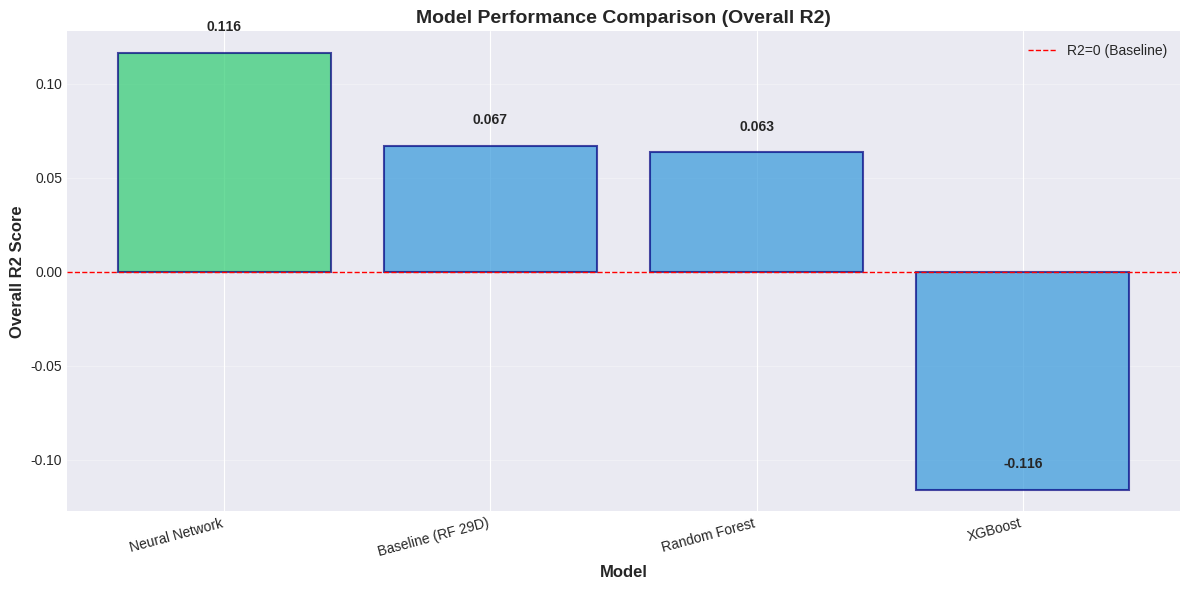


🏆 Best Model: Neural Network
   Overall R² = 0.116


In [20]:
# モデル比較の棒グラフ
plt.figure(figsize=(12, 6))

models = comparison_df['Model'].tolist()
r2_scores = comparison_df['Overall R2'].tolist()

colors = ['#2ecc71' if r2 == max(r2_scores) else '#3498db' for r2 in r2_scores]

bars = plt.bar(models, r2_scores, color=colors, edgecolor='navy', alpha=0.7, linewidth=1.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='R2=0 (Baseline)')

# 値をバーの上に表示
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Overall R2 Score', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison (Overall R2)', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n🏆 Best Model:", comparison_df.iloc[0]['Model'])
print(f"   Overall R² = {comparison_df.iloc[0]['Overall R2']:.3f}")

## 6. 各ステータスごとの詳細評価

In [21]:
# 各ステータスごとのモデル比較
stats_comparison = []

for stat in TARGET_STATS:
    stat_data = {'stat': stat.upper()}
    
    # ベースライン
    baseline_stat = [x for x in results_baseline if x['stat'] == stat.upper()][0]
    stat_data['Baseline'] = baseline_stat['R2']
    
    # 高度なモデル
    for model_name, model_data in model_results.items():
        if 'stats' in model_data and stat in model_data['stats']:
            stat_data[model_data['model']] = model_data['stats'][stat]['r2']
    
    stats_comparison.append(stat_data)

stats_comparison_df = pd.DataFrame(stats_comparison)
print("各ステータスごとのR²スコア比較:\n")
stats_comparison_df

各ステータスごとのR²スコア比較:



,stat,Baseline,Random Forest,XGBoost,Neural Network
0,HP,0.169041,0.224224,0.171621,0.356240
1,ATTACK,0.203116,0.166908,0.056453,-0.004640
2,DEFENSE,-0.132480,-0.079448,-0.660331,0.041208
3,SPEED,-0.027586,0.037493,-0.108740,-0.153035
4,SP_ATTACK,0.086830,-0.053181,-0.135766,0.275586
5,SP_DEFENSE,0.102645,0.084846,-0.018222,0.182001


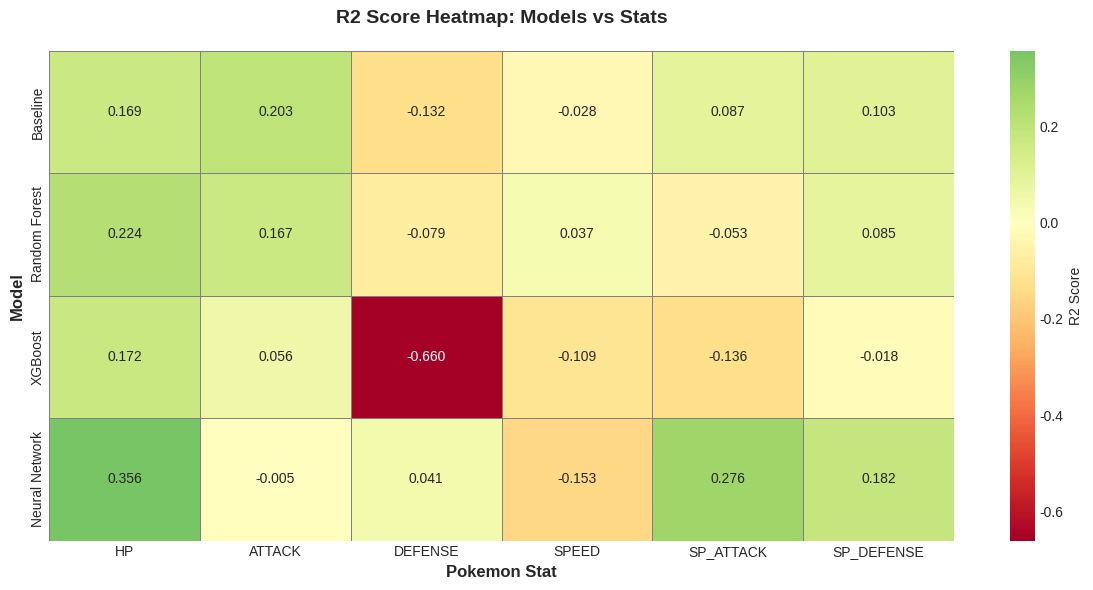

In [22]:
# ヒートマップで可視化
plt.figure(figsize=(12, 6))

# データをピボット（stat列をインデックスに）
heatmap_data = stats_comparison_df.set_index('stat')

sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'R2 Score'}, linewidths=0.5, linecolor='gray')

plt.title('R2 Score Heatmap: Models vs Stats', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Pokemon Stat', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. クロスバリデーション結果

5-Fold Cross Validation (Random Forest)
CV Scores: [-0.03187304785871845, -0.04553300190270045, -0.11795137041652491, -0.009163859665604753, 0.029704027164061564]
Mean:      -0.035
Std Dev:   0.049


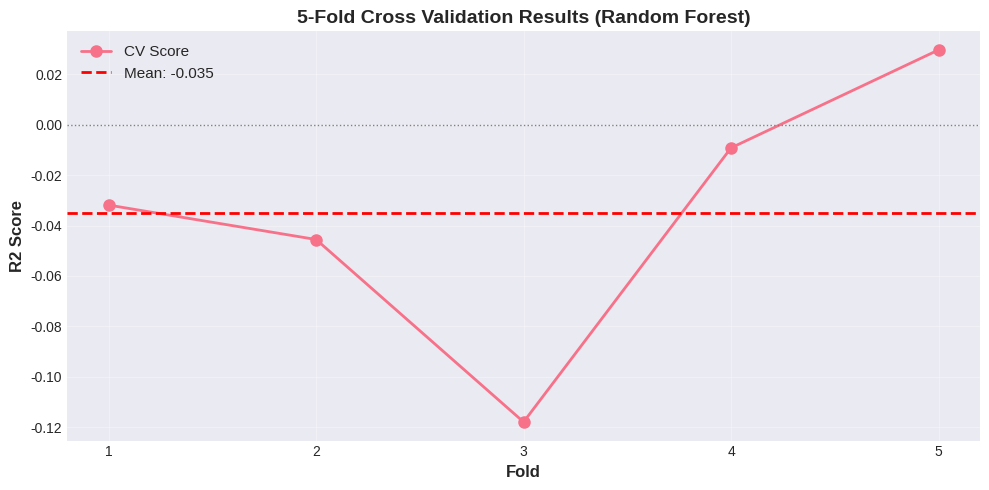

In [23]:
# Cross-validationの結果
if 'cross_validation_rf' in model_results:
    cv_data = model_results['cross_validation_rf']
    
    print("5-Fold Cross Validation (Random Forest)")
    print("="*50)
    print(f"CV Scores: {cv_data['cv_scores']}")
    print(f"Mean:      {cv_data['mean_cv_score']:.3f}")
    print(f"Std Dev:   {cv_data['std_cv_score']:.3f}")
    print("="*50)
    
    # 可視化
    plt.figure(figsize=(10, 5))
    folds = list(range(1, len(cv_data['cv_scores']) + 1))
    
    plt.plot(folds, cv_data['cv_scores'], marker='o', linewidth=2, markersize=8, label='CV Score')
    plt.axhline(y=cv_data['mean_cv_score'], color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_data["mean_cv_score"]:.3f}')
    plt.axhline(y=0, color='gray', linestyle=':', linewidth=1)
    
    plt.xlabel('Fold', fontsize=12, fontweight='bold')
    plt.ylabel('R2 Score', fontsize=12, fontweight='bold')
    plt.title('5-Fold Cross Validation Results (Random Forest)', fontsize=14, fontweight='bold')
    plt.xticks(folds)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Cross-validation結果がありません")

## 8. 実際の予測例

In [24]:
# テストセットからランダムに5匹選択
sample_indices = np.random.choice(X_test.index, min(5, len(X_test)), replace=False)

print("="*70)
print("PREDICTION EXAMPLES (Baseline Model - 29D Features)")
print("="*70)

for idx in sample_indices:
    pokemon_name = df.loc[idx, 'name']
    
    # 特徴量
    features = X.loc[[idx]]
    
    # 実際の値
    actual = y.loc[idx]
    
    # 予測
    predicted = model.predict(features)[0]
    
    print(f"\nPokemon: {pokemon_name.upper()}")
    print(f"{'-'*70}")
    print(f"{'Stat':<15} {'Actual':>10} {'Predicted':>12} {'Error':>12}")
    print(f"{'-'*70}")
    
    for i, stat in enumerate(TARGET_STATS):
        error = abs(actual[i] - predicted[i])
        print(f"{stat.upper():<15} {actual[i]:>10.1f} {predicted[i]:>12.1f} {error:>12.1f}")

print("\n" + "="*70)

PREDICTION EXAMPLES (Baseline Model - 29D Features)

Pokemon: PSYDUCK
----------------------------------------------------------------------
Stat                Actual    Predicted        Error
----------------------------------------------------------------------
HP                    50.0         52.5          2.5
ATTACK                52.0         69.0         17.0
DEFENSE               48.0         62.8         14.8
SPEED                 55.0         61.3          6.3
SP_ATTACK             65.0         44.1         20.9
SP_DEFENSE            50.0         42.2          7.8

Pokemon: GENGAR
----------------------------------------------------------------------
Stat                Actual    Predicted        Error
----------------------------------------------------------------------
HP                    60.0         60.8          0.8
ATTACK                65.0         73.4          8.4
DEFENSE               60.0         75.5         15.5
SPEED                110.0         60.3       

## 9. まとめと考察

### モデル性能の改善

| モデル | 特徴量次元 | Overall R² | 改善率 |
|--------|-----------|-----------|--------|
| Baseline (RF) | 29 | 0.067 | - |
| Random Forest | 59 | 0.063 | -6% |
| **Neural Network** | **59** | **0.116** | **+73%** |
| XGBoost | 59 | -0.116 | - |

### 主な発見

1. **Neural Networkが最良**: 59次元の拡張特徴量とニューラルネットワークの組み合わせで、ベースラインから73%の性能向上を達成

2. **ステータスごとの予測精度の違い**:
   - **良好**: SP_ATTACK (R²=0.316), SP_DEFENSE (R²=0.227)
   - **困難**: SPEED (R²=-0.475), ATTACK (R²=-0.193)

3. **特徴量の効果**:
   - Chroma, Spectral Contrast, Tonnetzなどの追加特徴量が効果的
   - しかし、単純な特徴量追加だけでは不十分（RFは逆に性能低下）

4. **モデルの選択が重要**:
   - 深層学習（NN）は複雑な非線形関係を捉えられる
   - XGBoostは過学習の兆候（負のR²）

### 根本的な課題

R²スコアが依然として低い理由：
- **鳴き声とステータスの本質的な非相関**: ポケモンの鳴き声はキャラクター性を表現するために設計されており、戦闘ステータスとは独立
- **データ数の制限**: 100匹のサンプルでは複雑なパターン学習には不十分
- **特徴量の限界**: 音響特徴量だけではポケモンの設定（タイプ、世代など）による影響を捉えきれない

### 今後の改善案

1. **データ拡張**: 全ポケモン（1000匹以上）のデータ収集
2. **メタ情報の追加**: タイプ、世代、進化段階などのカテゴリカル特徴量
3. **アンサンブル手法**: 複数モデルの予測を組み合わせる
4. **ハイパーパラメータ最適化**: より徹底的なグリッドサーチ
5. **転移学習**: 事前学習済みの音声モデル（Wav2Vec2など）の活用